In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import plotly
import typing as tp
from tqdm.notebook import tqdm
import random
import logging
import os
import plotly.graph_objects as go

pd.set_option('display.max_rows', 100)
plotly.offline.init_notebook_mode()

tqdm.pandas()

np.random.seed(2022)
random.seed(2022)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_taxi = pd.read_csv("data/taxi.csv")
df_taxi.head()

datetime  num_orders
0  01/03/2018 00:00           9
1  01/03/2018 00:10          14
2  01/03/2018 00:20          28
3  01/03/2018 00:30          20
4  01/03/2018 00:40          32

# 1. Clean & simple analytics

In [3]:
df_taxi.dtypes

datetime      object
num_orders     int64
dtype: object

In [4]:
df_taxi['datetime'] = pd.to_datetime(df_taxi['datetime'], format='%d/%m/%Y %H:%M')

In [5]:
df_taxi.datetime

0       2018-03-01 00:00:00
1       2018-03-01 00:10:00
2       2018-03-01 00:20:00
3       2018-03-01 00:30:00
4       2018-03-01 00:40:00
                ...        
26491   2018-08-31 23:10:00
26492   2018-08-31 23:20:00
26493   2018-08-31 23:30:00
26494   2018-08-31 23:40:00
26495   2018-08-31 23:50:00
Name: datetime, Length: 26496, dtype: datetime64[ns]

In [6]:
pd.infer_freq(df_taxi.datetime)

'10T'

It`s really cool and rare situation that we have dataset without missings

In [7]:
# plt.figure(figsize=(20,7))

# plt.plot(df_taxi['datetime'], df_taxi['num_orders'])

# plt.xlabel('time', fontsize=16)
# plt.ylabel('number', fontsize=16)
# plt.grid()

# plt.show()

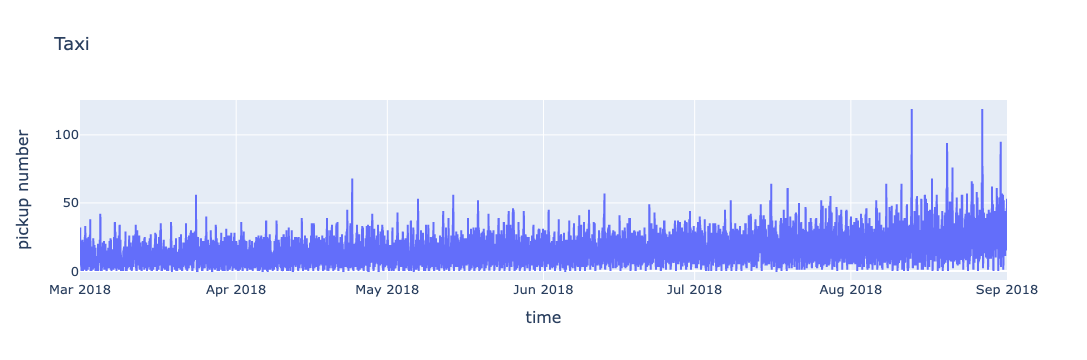

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_taxi.datetime, y=df_taxi.num_orders,
                    mode='lines'))

fig.update_layout(
    title=f"Taxi ",
    xaxis_title='time',
    yaxis_title=f"pickup number",
    font=dict(
        size=13,)
    )

Let's consider one week [5, 12] March

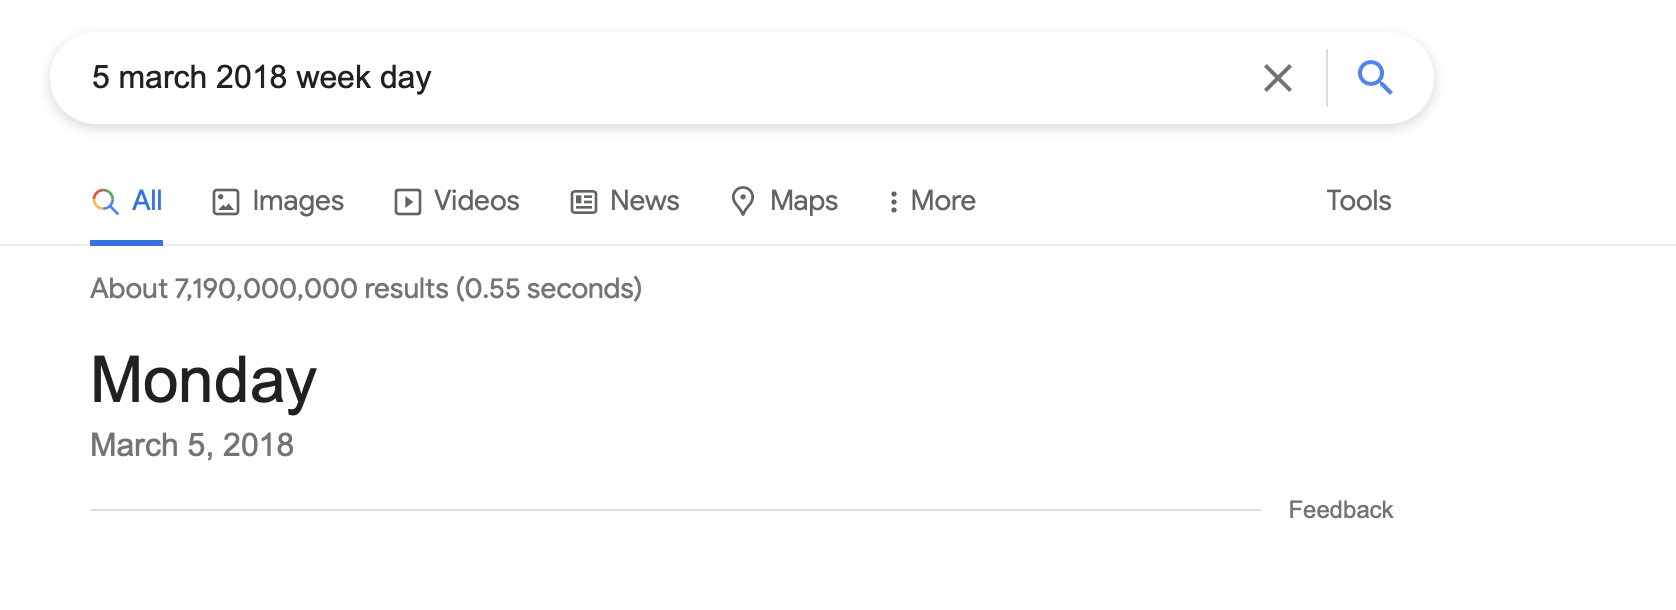


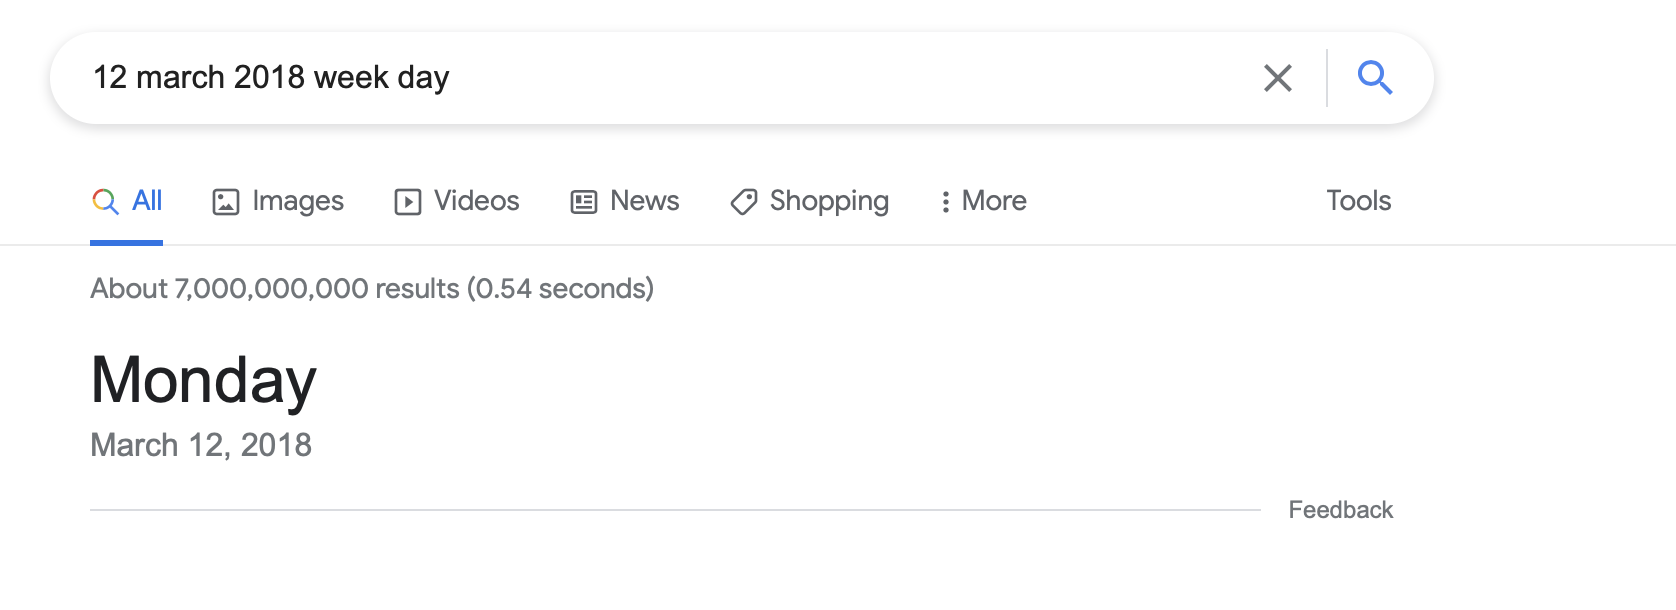

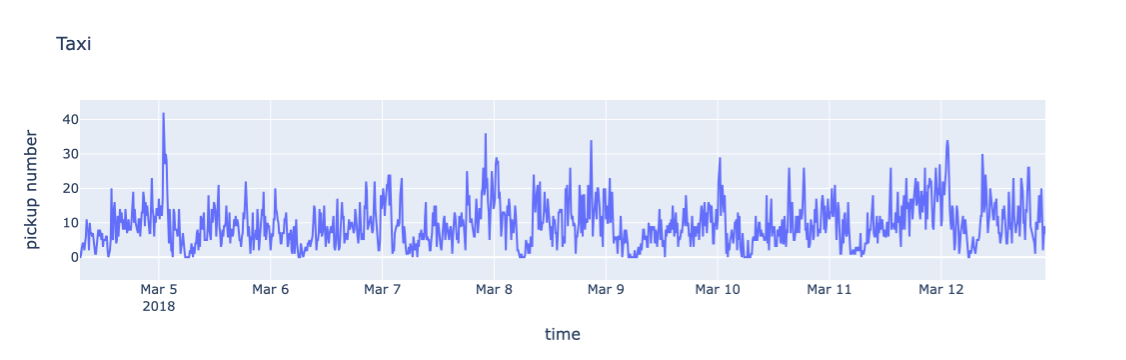

- So, we can see increasing trend during the day (morning – little number and increasin at night). 
- Dataset doesn't have any strange anomaly values
- Max values released at 13 August 2018 02:20-02:30 and Aug 27. But its'n look like outlier

In [9]:
df = df_taxi.set_index(df_taxi['datetime']) \
            .drop(columns='datetime')

/home/alekseyen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



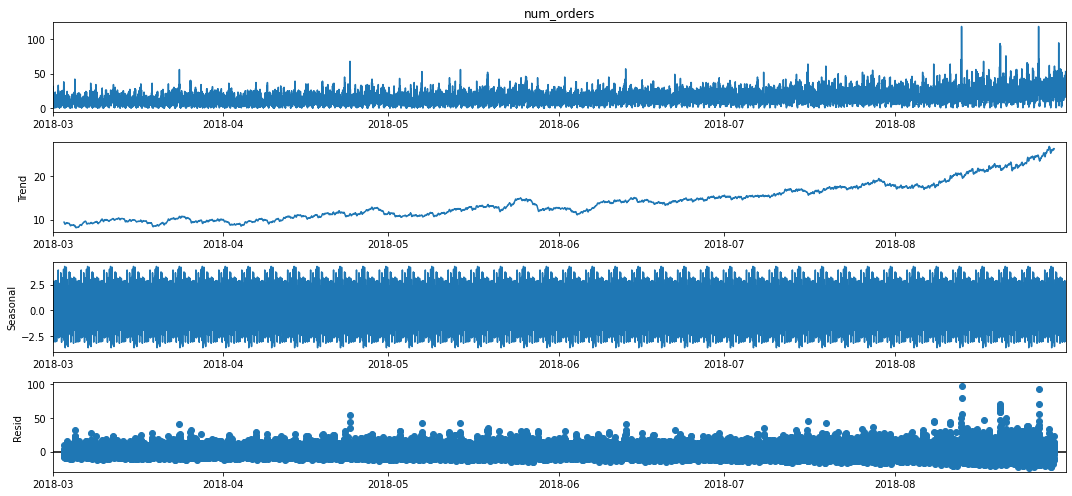

In [10]:
import statsmodels.api as sm

decomposed = sm.tsa.seasonal_decompose(df.num_orders, period=10 * 60)

fig = decomposed.plot()

fig.set_size_inches((15, 7))
fig.tight_layout()
plt.show()

# 2. Evaluate and split

In [11]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import functools


In [93]:
train, test = train_test_split(df, test_size=0.1, shuffle=False)

rmse calc:

In [94]:
rmse = functools.partial(mean_squared_error, squared=False)

# def rmse(predictions, targets):
#     return np.sqrt(np.mean((predictions - targets) ** 2))

In [95]:
# test

rmse([0.000, 0.166, 0.333], [0.000, 0.254, 0.998])

0.3872849941150143

# 3. Forecasting Baseline – Predective models

Do forecat without machine learning

## Exponential smoothing

In [115]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

fit3 = SimpleExpSmoothing(train, initialization_method="estimated").fit()

In [131]:
predicted = fit3.predict(start=test.index.min(), end=test.index.max())

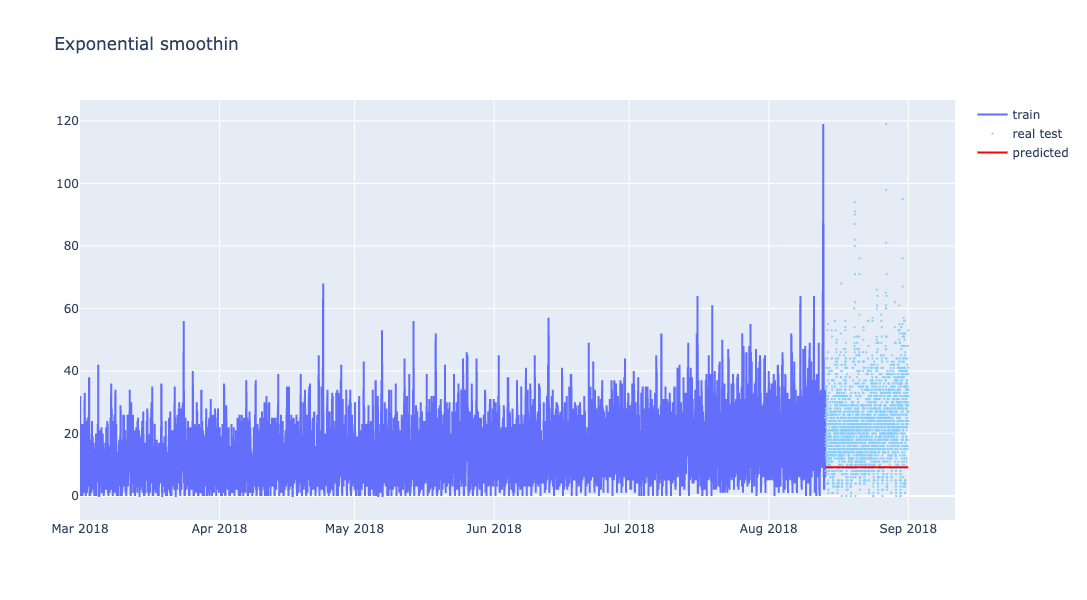

In [153]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train.num_orders, 
                         mode='lines', name='train'))

fig.add_trace(go.Scatter(
    x=test.index, y=test.num_orders,
    mode='markers', name='real test',
    marker=dict(
            color='LightSkyBlue',
            size=2,
        ),
))


fig.add_trace(go.Scatter(x=predicted.index, y=predicted.to_list(), 
                         mode='lines', name='predicted', line=dict(color="red")))



fig.update_layout(title='Exponential smoothin',
                  width=1111, height=600,)
fig.show()

In [156]:
rmse(predicted, test)

18.858524793720395

## TL:DR
- We have king STL components, thats why methods will be not good at this task
- Also, mabe should consider models:
    - statsmodels.tsa.holtwinters.ExponentialSmoothing
    - Theta

# 4. Forecasting – Prophet

In [99]:
from fbprophet import Prophet, plot

In [100]:
df_prophet = df.reset_index().rename(columns={"datetime": "ds", "num_orders": "y"})
df_prophet_train = train.reset_index().rename(columns={"datetime": "ds", "num_orders": "y"})


In [186]:
prophetModel = Prophet()
prophetModel.fit(df_prophet_train)

future = prophetModel.make_future_dataframe(periods = test.shape[0], freq='10T')
forecast = prophetModel.predict(future)

Initial log joint probability = -76.7246
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       57669.2     0.0035496       316.627           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       57675.2    0.00091135       518.821           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         57677   0.000736282       231.557           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       57677.8   0.000279278       327.585      0.2101      0.6447      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       57678.4   0.000262239       82.9141      0.7828      0.7828      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [187]:
fig = plot.plot_plotly(prophetModel, forecast) # to transform: m.history['y'] = np.exp(m.history['y'])

# fig.show() # <- slow, decide to save as separete file

_ = open('fbprophet_graph.html', 'w').write(fig.to_html(full_html=True, include_plotlyjs='cdn'))

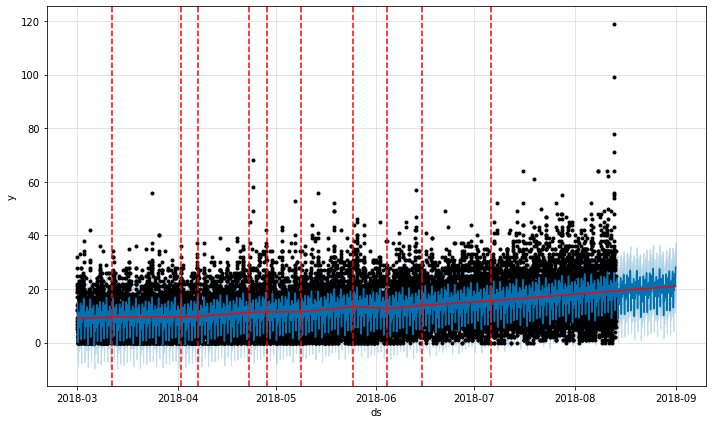

In [188]:
fig = prophetModel.plot(forecast)

a = plot.add_changepoints_to_plot(fig.gca(), prophetModel, forecast)

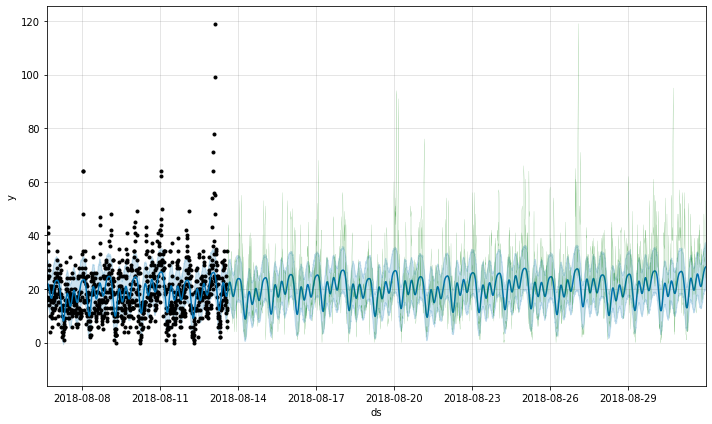

In [189]:
fig = prophetModel.plot(forecast)

ax = fig.gca()

ax.plot(test.index, test.num_orders, linewidth=0.1, color = 'green')

_ = ax.set_xlim(left=train.index[-1000], right=test.index.max()) 

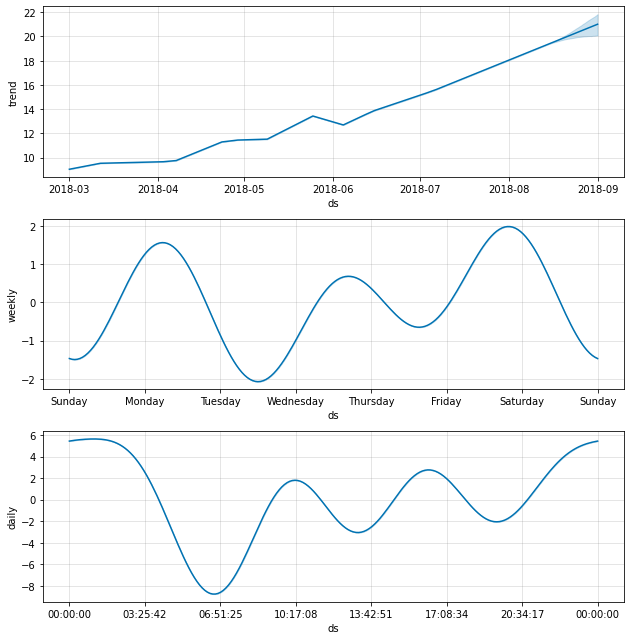

In [190]:
_ = prophetModel.plot_components(forecast)

In [201]:
rmse(test.num_orders.to_list(), forecast.iloc[-test.shape[0]:]['yhat'].to_list())

11.241762191161797

## Cross-validatoin

- df_prophet_trainperiod is how much data to add to the training data set in every iteration of cross-validation
- and horizon is how far out it will forecast

In [111]:
%%time

initial = str(max(df_prophet_train.ds) - min(df_prophet_train.ds))
horizon = '1 hours'
period = '1 hours'


m = Prophet().fit(df_prophet)

df_cv = cross_validation(m, 
                     initial=initial, 
                     period=period, 
                     horizon = horizon,
                     parallel= "processes")


Initial log joint probability = -405.915
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61887.9      0.012336       718.315           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       61895.3    0.00121496       567.461      0.5021           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       61899.7   0.000543633        385.35           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       61901.2   0.000159151       215.342      0.3751      0.7935      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       61901.9   0.000154213       231.693      0.2829           1      619   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [112]:
df_p = performance_metrics(df_cv)
df_p

horizon     mse   rmse   mae  mdape  coverage
0 0 days 00:10:00 129.256 11.369 7.847  0.272     0.680
1 0 days 00:20:00 115.089 10.728 7.465  0.280     0.673
2 0 days 00:30:00 108.607 10.421 7.626  0.278     0.676
3 0 days 00:40:00 108.319 10.408 7.882  0.283     0.630
4 0 days 00:50:00 116.662 10.801 7.946  0.291     0.630
5 0 days 01:00:00 116.169 10.778 7.854  0.276     0.649

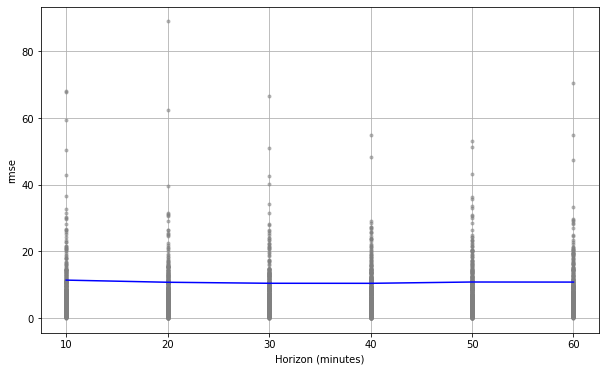

In [113]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='rmse')

## TL;DR prophet

- easy to parallel on CPU
    ![](imgs/prophet_performance.png)
    
- easy to use
- good enough quality

# Ideas

1. Using cross-validation choose better parameters for prophet
2. try boosting models
3. try neural models, neural prophet, for example
4. make timeseries transformation, for try log transform